In [9]:
import matplotlib
# %matplotlib inline
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
import matplotlib.pyplot as plt

import SUITPy as suit
import surfAnalysisPy as sa
import nibabel as nb
import nitools as nt

import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as am
import selective_recruitment.plotting as splotting
import selective_recruitment.scripts.script_overlap_map_wm as soverlap
import selective_recruitment.plotting as splotting
import selective_recruitment.globals as gl

from statsmodels.stats.anova import AnovaRM # perform F test
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')


In [10]:
wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
# create an instance of the dataset class
Data = fdata.get_dataset_class(gl.base_dir, dataset="WMFS")
# get list of subjects
T = Data.get_participants()
subject_list = list(T.participant_id.values)
subject_list.append("group")

Text(0.5, 1.0, 'fs32k')

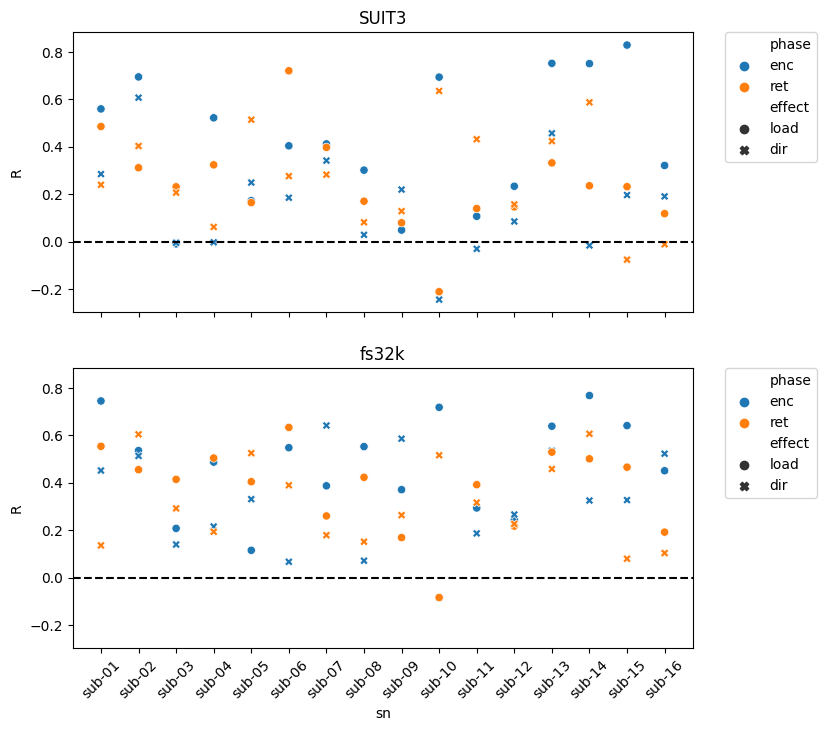

In [19]:
# without smoothing
D_split_rel = soverlap.get_summary_reliability(type = "CondHalf", 
                                               partition = "half",
                                               subtract_mean = False, 
                                               smooth = False 
                                               )
D_split_rel.to_csv(f"{wkdir}/load_recall_overlap_reliability.tsv", sep = "\t")
D1 = pd.read_csv(f"{wkdir}/load_recall_overlap_reliability.tsv", sep = '\t')
fig, axes = plt.subplots(2,1, figsize=(8, 8), sharey="col", sharex="col")
# put the dataframe into scatterplot
# sns.catplot(D1, 
#             x = "effect", 
#             y = "a_cron", 
#             hue = "atlas", 
#             col = "phase", 
#             errorbar= 'sd', 
#             kind = 'bar')

# plt.savefig(f"{wkdir}/figures/load_recall_reliability.png")
sns.scatterplot(data = D1.loc[D1.atlas == "SUIT3"],
                x = "sn", y = "R", 
                hue = "phase", 
                style = "effect", 
                ax = axes[0])
axes[0].axhline(y = 0,color = 'k', linestyle = '--')
plt.xticks(rotation=45)
axes[0].set_title("SUIT3")
sns.move_legend(axes[0], "upper right", bbox_to_anchor=(1.2, 1), borderaxespad=0)


sns.scatterplot(data = D1.loc[D1.atlas == "fs32k"],
                x = "sn", y = "R", 
                hue = "phase", 
                style = "effect", 
                ax = axes[1])

sns.move_legend(axes[1], "upper right", bbox_to_anchor=(1.2, 1), borderaxespad=0)
axes[1].axhline(y = 0,color = 'k', linestyle = '--')
plt.xticks(rotation=45)
axes[1].set_title("fs32k")

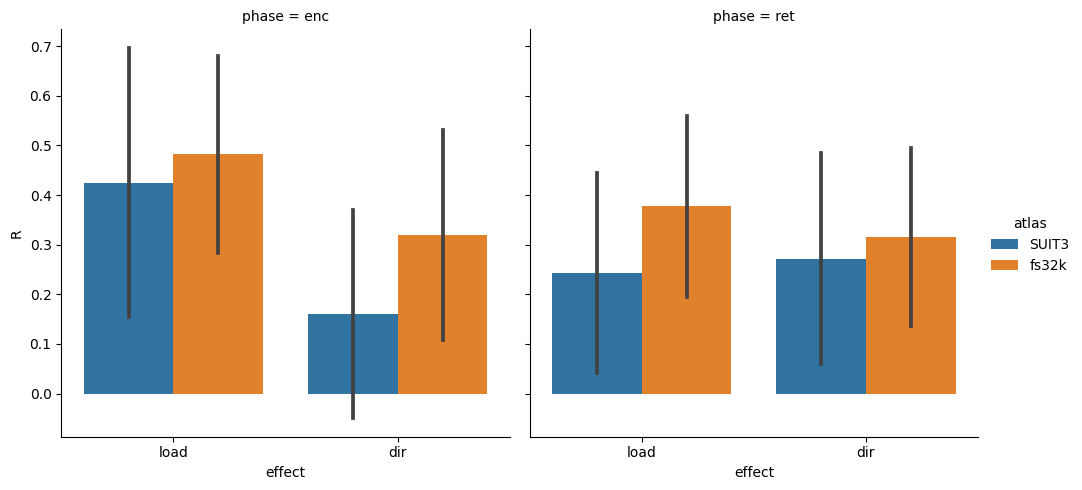

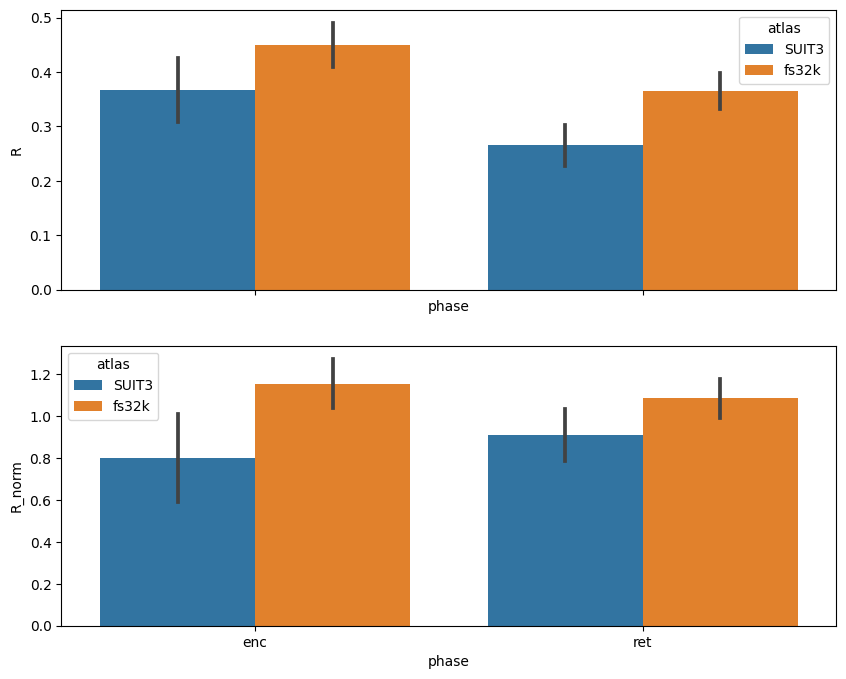

In [20]:
# without smoothing
D_overlap_corr = soverlap.get_summary_overlap(type = "CondHalf",
                                              partition = "half", 
                                              subtract_mean=False, 
                                              smooth = False)
D_overlap_corr.to_csv(f"{wkdir}/load_recall_overlap_corr.tsv", sep = "\t")
D2 = pd.read_csv(f"{wkdir}/load_recall_overlap_corr.tsv", sep = "\t")
# calculate geometric mean of reliability
D1_load = D1.loc[D1.effect == "load"]
D1_dir = D1.loc[D1.effect == "dir"]
A = np.sqrt(D1_load.R.values*D1_dir.R.values)

D2["geo_alpha"] = np.sqrt(D1_load.R.values*D1_dir.R.values)
# normalize overlap corr
D2["R_norm"] = D2["R"]/D2["geo_alpha"]
D2["R_norm"] = np.nan_to_num(D2["R_norm"])
sns.catplot(D1, 
            x = "effect", 
            y = "R", 
            hue = "atlas", 
            col = "phase", 
            errorbar= 'sd', 
            kind = 'bar')

fig, axes = plt.subplots(2,1, figsize=(10, 8), sharex="col")
sns.barplot(D2.loc[(D2.sn != "group")], x = "phase", 
            y = "R", 
            hue = "atlas", 
            errorbar= 'se', 
            ax = axes[0])
sns.barplot(D2.loc[(D2.sn != "group")], x = "phase", 
            y = "R_norm", 
            hue = "atlas", 
            errorbar= 'se', 
            ax = axes[1])
plt.savefig(f"{wkdir}/figures/overlap_corr.png")

In [21]:
print(AnovaRM(data=D2, depvar="R_norm",
              subject='sn', within=['phase', 'atlas'], aggregate_func = np.mean).fit())

                  Anova
            F Value Num DF  Den DF Pr > F
-----------------------------------------
phase        0.0278 1.0000 15.0000 0.8698
atlas        8.3529 1.0000 15.0000 0.0112
phase:atlas  0.3938 1.0000 15.0000 0.5397

